In [167]:
import numpy as np
import matplotlib.pylab as plt
import xarray as xr 
import rioxarray
myfile = "/data/GIMMS3G/LAI3g/Version4/Original/AVHRRBUVI04.2015juna.abl"
# with open("/data/GIMMS3G/LAI3g/Version4/Original/AVHRRBUVI04.1988apra.abl", mode='rb') as file: # b is important -> binary
#     byte = file.read()
#     while byte != b"":
#         # Do stuff with byte.
#         byte = file.read(1)
#         print(byte)
f = np.fromfile(myfile,dtype='>u2', count=-1)
data_orig = f.reshape([2160,4320],order="F")
data_orig = np.where(data_orig>20000,np.nan,data_orig)
lai = np.floor(data_orig/10)*10*0.001
qc = data_orig - np.floor(data_orig/10)*10

In [203]:
lat_vec = np.flip(np.linspace(-90,90,2160))
long_vec = np.linspace(0,360,4320)
# lat = np.empty((2160,4320))
# long = np.empty((2160,4320))
# for i in np.arange(2160):
#     for j in np.arange(4320):
#         lat[i,j] = lat_vec[i]
#         long[i,j] = long_vec[j]

da = xr.DataArray(
    data = lai,
    dims= ["lat","long"],
    coords = dict(lat=(["lat"],lat_vec),long=(["long"],long_vec))
    )
da

<xarray.DataArray (lat: 2160, long: 4320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 90.0 89.92 89.83 89.75 ... -89.75 -89.83 -89.92 -90.0
  * long     (long) float64 0.0 0.08335 0.1667 0.2501 ... 359.8 359.9 360.0

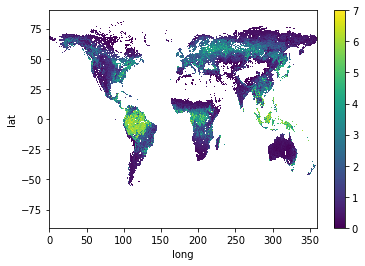

In [204]:
da.

In [194]:
(da.lon + 180)/ 360 - 180

<xarray.DataArray 'lon' (x: 2160, y: 4320)>
array([[-179.5       , -179.49976846, -179.49953693, ..., -178.50046307,
        -178.50023154, -178.5       ],
       [-179.5       , -179.49976846, -179.49953693, ..., -178.50046307,
        -178.50023154, -178.5       ],
       [-179.5       , -179.49976846, -179.49953693, ..., -178.50046307,
        -178.50023154, -178.5       ],
       ...,
       [-179.5       , -179.49976846, -179.49953693, ..., -178.50046307,
        -178.50023154, -178.5       ],
       [-179.5       , -179.49976846, -179.49953693, ..., -178.50046307,
        -178.50023154, -178.5       ],
       [-179.5       , -179.49976846, -179.49953693, ..., -178.50046307,
        -178.50023154, -178.5       ]])
Coordinates:
    lon      (x, y) float64 0.0 0.08335 0.1667 0.2501 ... 359.8 359.9 360.0
    lat      (x, y) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
Dimensions without coordinates: x, y

In [188]:
da.rio.write_crs(
    4326,
    inplace=True,
).rio.set_spatial_dims(
    x_dim="x",
    y_dim="y",
    inplace=True,
).rio.write_coordinate_system(inplace=True)


<xarray.DataArray (x: 2160, y: 4320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lon          (x, y) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
    lat          (x, y) float64 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0 -90.0
    spatial_ref  int64 0
Dimensions without coordinates: x, y

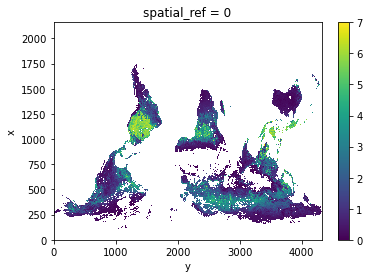

In [189]:
da.plot()

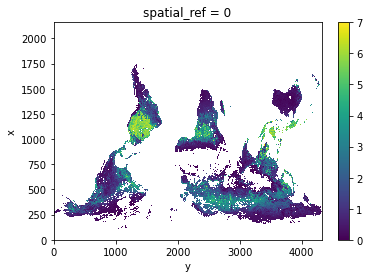

In [178]:
da.plot()

In [184]:
ds = xr.open_dataset("/data/home/hamiddashti/hamid/nasa_above/greeness/working/QA4ECV.ECV.avh_geo.res005.1986001.nc")
a = ds["Lai"].isel(time=0)
a

<xarray.DataArray 'Lai' (lat: 3600, lon: 7200)>
[25920000 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 1986-01-01
  * lon      (lon) float32 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * lat      (lat) float32 89.97 89.93 89.88 89.82 ... -89.88 -89.93 -89.97
Attributes:
    long_name:  Effective Leaf Area Index
    units:      1
    valid_min:  -0.1

In [18]:
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import ProgressBar
import matplotlib.pylab as plt
import my_funs

from dask.distributed import Client,LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)

# client = Client(processes=False)

dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/"
out_dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/working/"


def dist_matrix(x_size, y_size):
    import numpy as np

    a1 = np.floor(x_size / 2)
    a2 = np.floor(y_size / 2)
    x_arr, y_arr = np.mgrid[0:x_size, 0:y_size]
    cell = (a1, a2)
    dists = np.sqrt((x_arr - cell[0]) ** 2 + (y_arr - cell[1]) ** 2)
    dists[int(a1), int(a2)] = np.nan
    return dists


WINSIZE = 7
win_size_half = int(np.floor(WINSIZE / 2))
dist_m = dist_matrix(WINSIZE, WINSIZE)

percent_cover = xr.open_dataarray(
    dir + "data/processed_data/percent_cover/percent_cover.nc"
)
var_ts = xr.open_dataarray(
    dir + "data/processed_data/noaa_nc/lai_fapar/resampled/lai_growing.nc"
)

var_ts= var_ts.rename({"latitude":"lat","longitude":"lon"})
percent_cover = percent_cover.loc["1984":"2013"]
var_ts = var_ts[:,100:150,400:410]
percent_cover = percent_cover[:,:,100:150,400:410]


In [19]:
percent_cover = percent_cover.round(3)
# If a class is 0 change it no nan to prevent false zeros in diff later
percent_cover = percent_cover.where(percent_cover!=0)

### Calculating the slope using Theil-Sen and its significant using Kendall

In [44]:
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.linear_model import RANSACRegressor
import time


# y = var_region.values
# X = var_region.time.values.reshape(-1, 1)


def theilsen(y):
    x = np.arange(len(y)).reshape(-1, 1)
    if np.isnan(y).all():
        return

    I = np.where(np.isnan(y))
    if len(I[0]) > 1:
        return np.nan

    yy = np.delete(y, I)
    x = np.arange(len(yy)).reshape(-1, 1)
    # reg = TheilSenRegressor(random_state=1, n_subsamples=20, max_iter=300,n_jobs=-1).fit(x, yy)
    reg = TheilSenRegressor(random_state=0,n_subsamples=15).fit(x, yy)
    # reg = LinearRegression().fit(x, yy)
    return reg.coef_
    # return reg.estimator_.coef_


xrd = var_ts
data = xrd.values
yy = data[:,10,5:7]
x = np.arange(len(yy)).reshape(-1, 1)
from scipy.stats import theilslopes
reg  = theilslopes(yy)
reg.slope
# reg = TheilSenRegressor(random_state=0,n_subsamples=15).fit(x, yy)
# reg.coef_
# test = np.apply_along_axis(theilsen,0,data)

# y = xrd.time.values.reshape(-1, 1)
# trend = xr.apply_ufunc(
#     theilsen,
#     xrd,
#     input_core_dims=[["time"]],
#     # dask="allowed",
#     # output_dtypes=float,
#     vectorize=True,

# )
# trend = my_funs.xarray_Linear_trend(xrd,"LAI")
# trend = trend["slope"]

nan

### Find stable pixels

In [19]:
lc_diff = percent_cover.diff("time")*100
diff = (abs(lc_diff)>10)*1
changed_pixels = (diff==1).any(dim=["time","band"])
changed_pixels

<xarray.DataArray (lat: 448, lon: 1348)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lat      (lat) float64 74.53 74.48 74.43 74.38 ... 52.32 52.27 52.22 52.17
  * lon      (lon) float64 -168.1 -168.0 -168.0 -167.9 ... -100.8 -100.8 -100.7

### Calculate natural variability 

In [20]:
trend_roll = (
    trend.rolling({"lat": WINSIZE, "lon": WINSIZE}, center=True)
    .construct({"lat": "lat_dim", "lon": "lon_dim"})
    .values
)
changed_pixels_roll = (
    changed_pixels.rolling({"lat": WINSIZE, "lon": WINSIZE}, center=True)
    .construct({"lat": "lat_dim", "lon": "lon_dim"})
    .values
)
percent_cover_roll = (
    percent_cover.rolling({"lat": WINSIZE, "lon": WINSIZE}, center=True)
    .construct({"lat": "lat_dim", "lon": "lon_dim"})
    .values
)
percent_cover_roll.shape

(30, 10, 448, 1348, 7, 7)

In [21]:
trend_res = xr.full_like(trend, fill_value=np.nan, dtype=float)


for i in range(0, changed_pixels.shape[0]):
    for j in range(0, changed_pixels.shape[1]):

        # Continue if central pixel not changed
        if changed_pixels_roll[i, j][win_size_half, win_size_half] == 0:
            continue

        mask = changed_pixels_roll[i, j]

        dist_m_mask = dist_m[np.where(mask == False)]

        # Continue if there is no neighbor pixel with LC change
        if len(dist_m_mask) == 0:
            continue
        trend_tmp = trend_roll[i, j]

        trend_tmp_masked = trend_tmp[np.where(mask == False)]
        tmp_var1 = np.nansum(trend_tmp_masked / dist_m_mask)
        trend_res[i, j] = tmp_var1 / (np.nansum(dist_m_mask))

# The following lines are checking if the central pixl has exactly same pixel as the neighbors
# percent_cover_tmp = percent_cover_roll[:,:,i,j,:,:] #shape (30, 10, winsize, winsize)
# # center_lc = np.isfinite(lc_changed_tmp[:,:,win_size_half,win_size_half])
# lc_type = np.isfinite(percent_cover_tmp[:,:,:,:]) #shape (30, 10, winsize, winsize)
# center_lc = lc_type[:,:,win_size_half,win_size_half] # shape (30,10)
# lc_not_changed = np.argwhere(mask==0)
# for m in range(len(lc_not_changed)):
#     neighbor_lc = lc_type[:,:,lc_not_changed[m][0],lc_not_changed[m][1]]
#     a = np.equal(center_lc,neighbor_lc)
# print(lc_not_changed[m],a.all())
trend_lcc = trend - trend_res

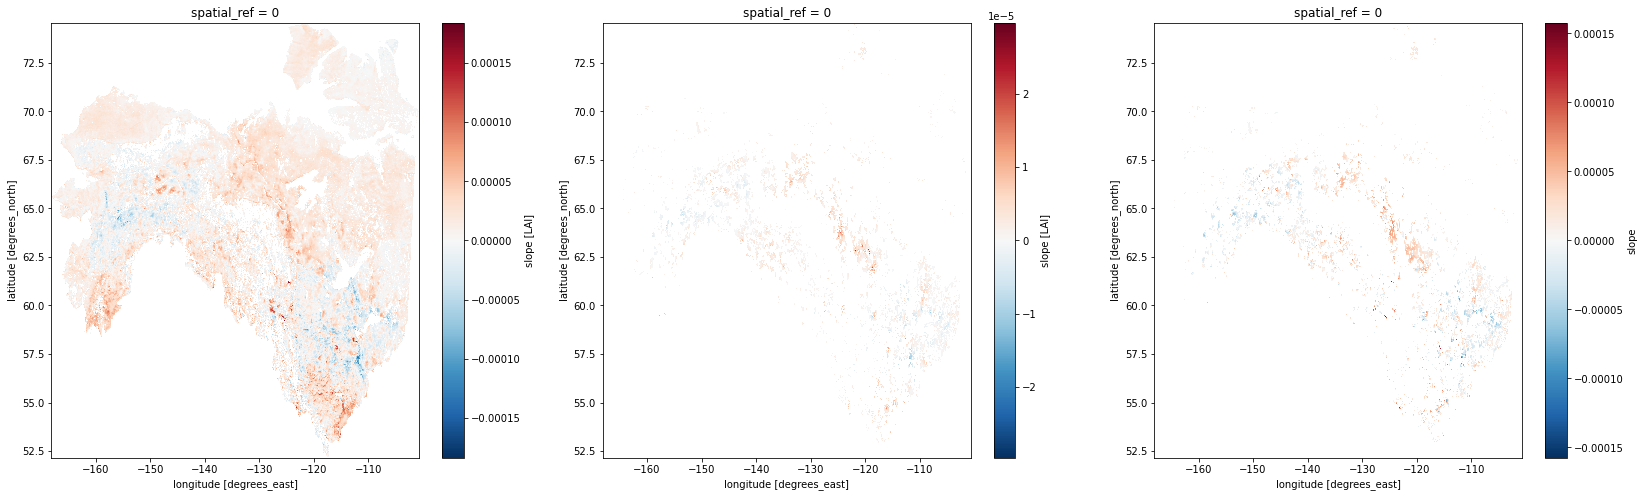

In [24]:
plt.figure(figsize=(28,8))
plt.subplot(131)
trend.plot()
plt.subplot(132)
trend_res.plot()
plt.subplot(133)
trend_lcc.plot()



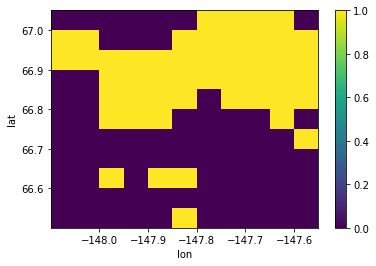

In [ ]:

for i in range(0, changed_pixels.shape[0]):
    for j in range(0, changed_pixels.shape[1]):
        if changed_pixels[i, j] == 0:
            continue
        mask = changed_pixels_roll[i, j]
        dist_m_mask = dist_m[np.where(mask == 0)]

        if len(dist_m_mask) == 0:
            continue

        dlst_tmp = dlst_total_roll[i, j]
        dlst_mask = dlst_tmp[np.where(mask == 0)]
        tmp_var1 = np.nansum(dlst_mask / dist_m_mask)
        dlst_res[i, j] = tmp_var1 / (np.nansum(dist_m_mask))
